In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
weights = np.load('net_fit_priors1.npz')

In [3]:
W = weights["W"]

In [4]:
norm_mat = np.empty((W.shape[0], W.shape[0]))
for cell in range(W.shape[0]):
    for connection in range(W.shape[1]):
        norm_mat[cell, connection] = np.linalg.norm(W[cell][connection])
        

Text(0,0.5,'Connection Filter Norm')

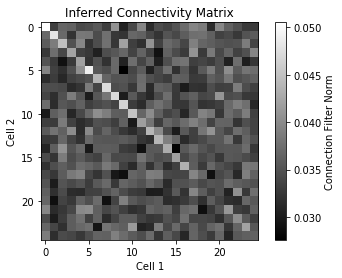

In [5]:
ax = plt.imshow(norm_mat, cmap = 'gray')
plt.xlabel("Cell 1")
plt.ylabel("Cell 2")
plt.title("Inferred Connectivity Matrix")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Connection Filter Norm")
#plt.savefig("l1_regularization_1em4")


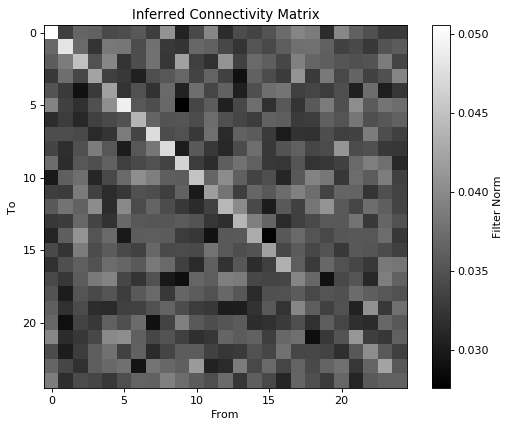

In [6]:
from matplotlib import rc
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = plt.imshow(norm_mat, cmap = 'gray')
plt.xlabel("From")
plt.ylabel("To")
plt.title("Inferred Connectivity Matrix")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Filter Norm")
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

rc('font', **font)
plt.savefig("no_regularization")

In [7]:
W.shape

(25, 25, 40)

Text(0,0.5,'example self interaction filter')

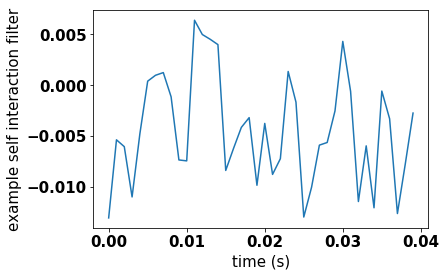

In [26]:
d=W.shape[-1]
bin_len = 0.001
t = np.arange(d)*bin_len
plt.plot(t,W[-9,-9,:])
plt.xlabel('time (s)')
plt.ylabel('example self interaction filter')

In [9]:
# F = np.load('plots_data/Fvisp_l1_1em4')

In [10]:
def bin_spikes(data_set,bin_len,t_start,t_final,probes=None,regions=None):
    if probes is None:
        probes = data_set.probe_list
    if regions is None:
        regions = data_set.unit_df.structure.unique()
    
    #gather cells from desired regions and probes into cell_table
    use_cells = False
    for probe in probes:
        for region in regions:
            use_cells |= (data_set.unit_df.probe==probe) & (data_set.unit_df.structure==region)
    cell_table = data_set.unit_df[use_cells]
    
    N = len(cell_table)     #number of cells
    T = int(np.floor((t_final-t_start)/bin_len)) #number of time bins
    binned_spikes = np.zeros((N,T)) # binned_spikes[i,j] is the number of spikes from neuron i in time bin j

    #for each cell in the table, add each spike to the appropriate bin
    i = 0
    for z,cell in cell_table.iterrows(): 
        for spike_time in data_set.spike_times[cell['probe']][cell['unit_id']]:
            t = int(np.floor((spike_time-t_start)/bin_len))
            if (t >=0) & (t<T):
                binned_spikes[i,t] += 1
        i+=1    
    return (binned_spikes, cell_table)

In [11]:
from swdb_2018_neuropixels.ephys_nwb_adapter import NWB_adapter
import os
import pandas as pd

drive_path = '/data/dynamic-brain-workshop/visual_coding_neuropixels'
manifest_file = os.path.join(drive_path,'ephys_manifest.csv')
expt_info_df = pd.read_csv(manifest_file)
multi_probe_expt_info = expt_info_df[expt_info_df.experiment_type == 'multi_probe']
multi_probe_example = 1 # index to row in multi_probe_expt_info
multi_probe_filename  = multi_probe_expt_info.iloc[multi_probe_example]['nwb_filename']
nwb_file = os.path.join(drive_path,multi_probe_filename)
data_set = NWB_adapter(nwb_file)



In [12]:
stim_table = data_set.get_stimulus_table("natural_scenes")
bin_len = 0.001
num_stim_rows = 400
tns_start = stim_table.iloc[0].values[0]
tns_end = stim_table.iloc[num_stim_rows].values[1]
print(tns_start)
print(tns_end)


5908.725920000001
6009.07438


In [13]:
(binned_spikes, cell_table) = bin_spikes(data_set,bin_len,tns_start,tns_end,regions=['VISp'])

In [14]:
# cell_table.depth.values[idxs]

NameError: name 'idxs' is not defined

In [20]:
k = 25
idxs = np.argsort(binned_spikes.sum(axis=1))
# print binned_spikes.sum(axis=1)[idxs]
reduced_binned_spikes = binned_spikes[idxs[-k:],:]

small_mat = norm_mat #our W mat connections
medium_mat = np.zeros((71,71))
medium_mat[-k:,-k:] = small_mat
depths = cell_table.depth.values[idxs]
re_order = np.argsort(-depths) #negative to put shallower cells at the beginning
mat_ordered_by_depths = medium_mat[:,re_order]
mat_ordered_by_depths = mat_ordered_by_depths[re_order,:]

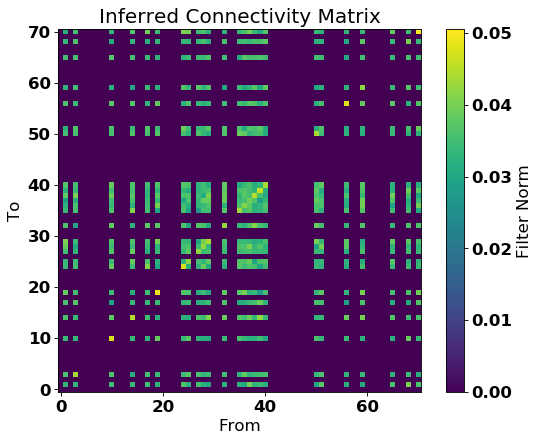

In [21]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = plt.imshow(mat_ordered_by_depths, origin = 'lower')
plt.xlabel("From")
plt.ylabel("To")
plt.title("Inferred Connectivity Matrix")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Filter Norm")
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

rc('font', **font)
plt.savefig("comparison_connectivity")